In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters

from HelperFunctions.FileReader  import FileReader

run_time = 29 # minutes

def heat_loss_calculator(run_name):
    run_path_tsg = './TSGscreen/'
    run_path_feeder = './Feederdata/'
    run_path_eyecon = './Eyecondata/'
    combined_datafile = pd.DataFrame()
    # for run_name in run_name_all:

    fr_obj = FileReader(run_name)

    tsg_data = fr_obj.read_excelFile(run_path_tsg,0)
    feeder_data = fr_obj.read_excelFile(run_path_feeder,1)
    eyecon_data = fr_obj.read_excelFile(run_path_eyecon,0)

    max_len = min(len(tsg_data),len(feeder_data))
    tsg_data = tsg_data[:max_len]
    feeder_data = feeder_data[:max_len]
    # print((tsg_data))
    # print(len(eyecon_data))
    # print(len(feeder_data))
    rpm = tsg_data['Actual RPM'] * (2*np.pi/60) # converting to radians per second

        # combined_datafile = combined_datafile.append(fr_obj.combine_datafiles(tsg_data,eyecon_data,feeder_data))
        # print(len(combined_datafile))
    tau_dry = tsg_data["Torque"][12]
    # print('\ntau empty = ',tau_dry)
    torque = tsg_data["Torque"]
    tau_empty = tsg_data["Torque"][1]
    # print(tau_empty)
    cp = 0.8
    lambda_guess = 2.5
    ls_ratio = 1
    # feeder_data = feeder_data.drop(index=feeder_data.index[:1],axis=0)
    # print(feeder_data)
    mass_flow_rate = np.array(feeder_data['Mass flow rate'])
    # calculating heat lost by granules +  jacket
    T_inlet = tsg_data['Zone 2'][0]
    
    
    # Powder inlet is in zone 2 and water is added in zone 3
    
    dt87 = np.array(tsg_data['Zone 8'] - tsg_data['Zone 7'])
    dt76 = np.array(tsg_data['Zone 7'] - tsg_data['Zone 6'])
    dt65 = np.array(tsg_data['Zone 6'] - tsg_data['Zone 5'])
    dt54 = np.array(tsg_data['Zone 5'] - tsg_data['Zone 4'])
    dt43 = np.array(tsg_data['Zone 4'] - tsg_data['Zone 3'])
    dt32 = np.array(tsg_data['Zone 3'] - tsg_data['Zone 2'])
    dt2inlet = np.array(tsg_data['Zone 2'] - T_inlet)

    dt_array = np.column_stack((dt2inlet, dt32, dt43, dt54, dt65, dt76, dt87))

    heat_lost_compartment = np.zeros_like(dt_array)
    heat_lost_compartment = heat_lost_compartment.astype('float64')

    for i in range(1,len(mass_flow_rate)):
        # print(i)
        heat_lost_compartment[i,:] = abs((cp + ls_ratio)/(2*3600) * 5 * np.multiply((1+ls_ratio)*mass_flow_rate[i], dt_array[i]))

    tot_heat_lost = sum(sum(heat_lost_compartment))
    # print(tot_heat_lost)
    heat_lost_compartment_cumsum = np.cumsum(heat_lost_compartment,axis=0)
    # print(heat_lost_compartment_cumsum)
    
    # Heat gained by equipment 
    # weight of equipment 
    wt_lower_jacket = 2.5809 # kgs
    wt_top_jacket = 2.9109 #kgs
    wt_screws = 0.3454 # kgs
    
    cp_ss = 0.468 # kJ/kgK
    
    dt_time_2 = np.array([tsg_data['Zone 2'][i+1] - tsg_data['Zone 2'][i] for i in range(0,len(tsg_data['Zone 2'])-1)])
    dt_time_3 = np.array([tsg_data['Zone 3'][i+1] - tsg_data['Zone 3'][i] for i in range(0,len(tsg_data['Zone 3'])-1)])
    dt_time_4 = np.array([tsg_data['Zone 4'][i+1] - tsg_data['Zone 4'][i] for i in range(0,len(tsg_data['Zone 4'])-1)])
    dt_time_5 = np.array([tsg_data['Zone 5'][i+1] - tsg_data['Zone 5'][i] for i in range(0,len(tsg_data['Zone 5'])-1)])
    dt_time_6 = np.array([tsg_data['Zone 6'][i+1] - tsg_data['Zone 6'][i] for i in range(0,len(tsg_data['Zone 6'])-1)])
    dt_time_7 = np.array([tsg_data['Zone 7'][i+1] - tsg_data['Zone 7'][i] for i in range(0,len(tsg_data['Zone 7'])-1)])
    dt_time_8 = np.array([tsg_data['Zone 8'][i+1] - tsg_data['Zone 8'][i] for i in range(0,len(tsg_data['Zone 8'])-1)])

    # Assuming equal mass distribution through out the equipment
    
    tot_eq_wt = wt_lower_jacket + wt_top_jacket + wt_screws
    eq_heat_gained_2 = (1.0/7) * tot_eq_wt * cp_ss * dt_time_2
    eq_heat_gained_3 = (1.0/7) * tot_eq_wt * cp_ss * dt_time_3
    eq_heat_gained_4 = (1.0/7) * tot_eq_wt * cp_ss * dt_time_4
    eq_heat_gained_5 = (1.0/7) * tot_eq_wt * cp_ss * dt_time_5
    eq_heat_gained_6 = (1.0/7) * tot_eq_wt * cp_ss * dt_time_6
    eq_heat_gained_7 = (1.0/7) * tot_eq_wt * cp_ss * dt_time_7
    eq_heat_gained_8 = (1.0/7) * tot_eq_wt * cp_ss * dt_time_8
    
    eq_heat_data = np.column_stack((eq_heat_gained_2,eq_heat_gained_3,eq_heat_gained_4,eq_heat_gained_5,eq_heat_gained_6,eq_heat_gained_7,eq_heat_gained_8))
    
    # print((eq_heat_data.size))
    equipment_heat_gained = pd.DataFrame(data=eq_heat_data,columns=['Zone 2','Zone 3','Zone 4','Zone 5','Zone 6','Zone 7','Zone 8'])
    # print(equipment_heat_gained)
    
    equipment_heat_lost_total = np.sum([np.sum(eq_heat_gained_2),np.sum(eq_heat_gained_3),np.sum(eq_heat_gained_4),np.sum(eq_heat_gained_5),np.sum(eq_heat_gained_6),np.sum(eq_heat_gained_7),np.sum(eq_heat_gained_8)])
    

    # print([eq_heat_gained_2_overtime,eq_heat_gained_3_overtime,eq_heat_gained_4_overtime,eq_heat_gained_5_overtime,eq_heat_gained_6_overtime,eq_heat_gained_7_overtime,eq_heat_gained_8_overtime])
    # print(total_heat_loss_overtime_to_equipment)
    
    # time = np.zeros((len(feeder_data['Time'],)))
    # for j  in range(len(feeder_data['Time'])):
    #     time[j] = datetime.strptime(feeder_data['Time'][j],"%H:%M:%S")

    time = feeder_data["Time"]

    # torque and energy calculations
    g = 9.81
    ph_actual = mass_flow_rate*(1+ls_ratio) * (lambda_guess * g / 3600) 
    ph_torque = tau_dry
    pn_torque = tau_empty

    tau_diff_ph_actual = 5 * np.multiply(rpm,(torque - ph_actual)) / 1000
    tau_diff_ph_torque = 5 * np.multiply(rpm,(torque - ph_torque)) / 1000
    tau_diff_pha_pn = 5 * np.multiply(rpm,(torque - ph_actual - pn_torque)) / 1000
    tau_diff_pht_pn = 5 * np.multiply(rpm,(torque - ph_torque - pn_torque)) / 1000

    # print(tau_diff_ph_actual)
    tau_diff_ph_actual_cumsum = np.cumsum(tau_diff_ph_actual)
    tau_diff_ph_torque_cumsum = np.cumsum(tau_diff_ph_torque)
    tau_diff_pha_pn_cumsum = np.cumsum(tau_diff_pha_pn)
    tau_diff_pht_pn_cumsum = np.cumsum(tau_diff_pht_pn)

    diff_tau = np.column_stack((tau_diff_ph_actual,tau_diff_ph_torque,tau_diff_pha_pn,tau_diff_pht_pn))
    # print(diff_tau)

    # Work done for granulations
    total_heat_loss_allcomps_with_time = np.sum(heat_lost_compartment[:,:5],axis=1) # - total_heat_loss_overtime_to_equipment)#,keepdims=True)) 

    # print((total_heat_loss_allcomps_with_time))
    # Using Equation 8
    work_granulation = tau_diff_ph_actual - (total_heat_loss_allcomps_with_time) 
    work_granulation_pn = tau_diff_pha_pn - (total_heat_loss_allcomps_with_time)

    # work_granulation = tau_diff_ph_torque - (total_heat_loss_allcomps_with_time) 
    # work_granulation_pn = tau_diff_pht_pn - (total_heat_loss_allcomps_with_time)


    # # Using Equation 9
    # work_granulation = (total_heat_loss_allcomps_with_time) - tau_diff_ph_torque
    # work_granulation_pn = (total_heat_loss_allcomps_with_time) - tau_diff_pht_pn

    # print(work_granulation)
    # print(work_granulation_pn)
    work_granulation_total = np.trapz(work_granulation) - equipment_heat_lost_total
    work_granulation_pn_total = np.trapz(work_granulation_pn) - equipment_heat_lost_total
    # total_work_granulation = np.trapz(work_granulation) - equipment_heat_lost_total
    # print(total_work_granulation)
    print("Work of granulation eq 8 in ",run_name,"= ",work_granulation_total)
    print("Work of granulation eq 9 in ",run_name,"= ",work_granulation_pn_total)

    return time, heat_lost_compartment, tau_diff_ph_actual, work_granulation, work_granulation_pn, equipment_heat_gained


# run_name_1 = 'Run1.xlsx'
# time_1, heat_lost_compartment_1, tau_diff_ph_actual_1, work_granulation_1, work_granulation_pn_1, equipment_heat_gained_1 = heat_loss_calculator(run_name_1)


In [26]:
run_name_1 = 'Run1.xlsx'
run_name_2 = 'Run2.xlsx'
run_name_3 = 'Run3.xlsx'
run_name_4 = 'Run4.xlsx'
run_name_5 = 'Run5.xlsx'
run_name_6 = 'Run6.xlsx'


time_1, heat_lost_compartment_1, tau_diff_ph_actual_1, work_granulation_1, work_granulation_pn_1, equipment_heat_gained_1 = heat_loss_calculator(run_name_1)
heat_lost_compartment_cumsum_1 = np.cumsum(heat_lost_compartment_1,axis=0)
total_heat_loss_allcomps_with_time_1 = np.sum(heat_lost_compartment_1[:,1:],axis=1)
total_heat_loss_toequip_withtime_1 = np.sum(equipment_heat_gained_1[:],axis=1)
work_granulation_cumsum_1 = np.cumsum(work_granulation_1) - np.cumsum(total_heat_loss_toequip_withtime_1)
work_granulation_pn_cumsum_1 = np.cumsum(work_granulation_pn_1) - np.cumsum(total_heat_loss_toequip_withtime_1)
tau_diff_ph_actual_cumsum_1 = np.cumsum(tau_diff_ph_actual_1)
eq_heat_gained_2_overtime_1 = np.trapz(equipment_heat_gained_1['Zone 2'])
eq_heat_gained_3_overtime_1 = np.trapz(equipment_heat_gained_1['Zone 3'])
eq_heat_gained_4_overtime_1 = np.trapz(equipment_heat_gained_1['Zone 4'])
eq_heat_gained_5_overtime_1 = np.trapz(equipment_heat_gained_1['Zone 5'])
eq_heat_gained_6_overtime_1 = np.trapz(equipment_heat_gained_1['Zone 6'])
eq_heat_gained_7_overtime_1 = np.trapz(equipment_heat_gained_1['Zone 7'])
eq_heat_gained_8_overtime_1 = np.trapz(equipment_heat_gained_1['Zone 8'])

total_heat_loss_overtime_to_equipment_1 = eq_heat_gained_2_overtime_1 \
                                        + eq_heat_gained_3_overtime_1 \
                                        + eq_heat_gained_4_overtime_1 \
                                        + eq_heat_gained_5_overtime_1 \
                                        + eq_heat_gained_6_overtime_1 \
                                        + eq_heat_gained_7_overtime_1 \
                                        + eq_heat_gained_8_overtime_1

time_2, heat_lost_compartment_2, tau_diff_ph_actual_2, work_granulation_2, work_granulation_pn_2, equipment_heat_gained_2 = heat_loss_calculator(run_name_2)
heat_lost_compartment_cumsum_2 = np.cumsum(heat_lost_compartment_2,axis=0)
total_heat_loss_allcomps_with_time_2 = np.sum(heat_lost_compartment_2[:,1:],axis=1)
total_heat_loss_toequip_withtime_2 = np.sum(equipment_heat_gained_2[:],axis=1)
work_granulation_cumsum_2 = np.cumsum(work_granulation_2) - np.cumsum(total_heat_loss_toequip_withtime_2)
work_granulation_pn_cumsum_2 = np.cumsum(work_granulation_pn_2) - np.cumsum(total_heat_loss_toequip_withtime_2)
tau_diff_ph_actual_cumsum_2 = np.cumsum(tau_diff_ph_actual_2)
eq_heat_gained_2_overtime_2 = np.trapz(equipment_heat_gained_2['Zone 2'])
eq_heat_gained_3_overtime_2 = np.trapz(equipment_heat_gained_2['Zone 3'])
eq_heat_gained_4_overtime_2 = np.trapz(equipment_heat_gained_2['Zone 4'])
eq_heat_gained_5_overtime_2 = np.trapz(equipment_heat_gained_2['Zone 5'])
eq_heat_gained_6_overtime_2 = np.trapz(equipment_heat_gained_2['Zone 6'])
eq_heat_gained_7_overtime_2 = np.trapz(equipment_heat_gained_2['Zone 7'])
eq_heat_gained_8_overtime_2 = np.trapz(equipment_heat_gained_2['Zone 8'])

total_heat_loss_overtime_to_equipment_2 = eq_heat_gained_2_overtime_2 \
                                        + eq_heat_gained_3_overtime_2 \
                                        + eq_heat_gained_4_overtime_2 \
                                        + eq_heat_gained_5_overtime_2 \
                                        + eq_heat_gained_6_overtime_2 \
                                        + eq_heat_gained_7_overtime_2 \
                                        + eq_heat_gained_8_overtime_2

time_3, heat_lost_compartment_3, tau_diff_ph_actual_3, work_granulation_3, work_granulation_pn_3, equipment_heat_gained_3 = heat_loss_calculator(run_name_3)
heat_lost_compartment_cumsum_3 = np.cumsum(heat_lost_compartment_3,axis=0)
total_heat_loss_allcomps_with_time_3 = np.sum(heat_lost_compartment_3[:,1:],axis=1)
total_heat_loss_toequip_withtime_3 = np.sum(equipment_heat_gained_3[:],axis=1)
work_granulation_cumsum_3 = np.cumsum(work_granulation_3) - np.cumsum(total_heat_loss_toequip_withtime_3)
work_granulation_pn_cumsum_3 = np.cumsum(work_granulation_pn_3) - np.cumsum(total_heat_loss_toequip_withtime_3)
tau_diff_ph_actual_cumsum_3 = np.cumsum(tau_diff_ph_actual_3)
eq_heat_gained_2_overtime_3 = np.trapz(equipment_heat_gained_3['Zone 2'])
eq_heat_gained_3_overtime_3 = np.trapz(equipment_heat_gained_3['Zone 3'])
eq_heat_gained_4_overtime_3 = np.trapz(equipment_heat_gained_3['Zone 4'])
eq_heat_gained_5_overtime_3 = np.trapz(equipment_heat_gained_3['Zone 5'])
eq_heat_gained_6_overtime_3 = np.trapz(equipment_heat_gained_3['Zone 6'])
eq_heat_gained_7_overtime_3 = np.trapz(equipment_heat_gained_3['Zone 7'])
eq_heat_gained_8_overtime_3 = np.trapz(equipment_heat_gained_3['Zone 8'])

total_heat_loss_overtime_to_equipment_3 = eq_heat_gained_2_overtime_3 \
                                        + eq_heat_gained_3_overtime_3 \
                                        + eq_heat_gained_4_overtime_3 \
                                        + eq_heat_gained_5_overtime_3 \
                                        + eq_heat_gained_6_overtime_3 \
                                        + eq_heat_gained_7_overtime_3 \
                                        + eq_heat_gained_8_overtime_3

time_4, heat_lost_compartment_4, tau_diff_ph_actual_4, work_granulation_4, work_granulation_pn_4, equipment_heat_gained_4 = heat_loss_calculator(run_name_4)
heat_lost_compartment_cumsum_4 = np.cumsum(heat_lost_compartment_4,axis=0)
total_heat_loss_allcomps_with_time_4 = np.sum(heat_lost_compartment_4[:,1:],axis=1)
total_heat_loss_toequip_withtime_4 = np.sum(equipment_heat_gained_4[:],axis=1)
work_granulation_cumsum_4 = np.cumsum(work_granulation_4) - np.cumsum(total_heat_loss_toequip_withtime_4)
work_granulation_pn_cumsum_4 = np.cumsum(work_granulation_pn_4) - np.cumsum(total_heat_loss_toequip_withtime_4)
tau_diff_ph_actual_cumsum_4 = np.cumsum(tau_diff_ph_actual_4)
eq_heat_gained_2_overtime_4 = np.trapz(equipment_heat_gained_4['Zone 2'])
eq_heat_gained_3_overtime_4 = np.trapz(equipment_heat_gained_4['Zone 3'])
eq_heat_gained_4_overtime_4 = np.trapz(equipment_heat_gained_4['Zone 4'])
eq_heat_gained_5_overtime_4 = np.trapz(equipment_heat_gained_4['Zone 5'])
eq_heat_gained_6_overtime_4 = np.trapz(equipment_heat_gained_4['Zone 6'])
eq_heat_gained_7_overtime_4 = np.trapz(equipment_heat_gained_4['Zone 7'])
eq_heat_gained_8_overtime_4 = np.trapz(equipment_heat_gained_4['Zone 8'])

total_heat_loss_overtime_to_equipment_4 = eq_heat_gained_2_overtime_4 \
                                        + eq_heat_gained_3_overtime_4 \
                                        + eq_heat_gained_4_overtime_4 \
                                        + eq_heat_gained_5_overtime_4 \
                                        + eq_heat_gained_6_overtime_4 \
                                        + eq_heat_gained_7_overtime_4 \
                                        + eq_heat_gained_8_overtime_4

time_5, heat_lost_compartment_5, tau_diff_ph_actual_5, work_granulation_5, work_granulation_pn_5, equipment_heat_gained_5 = heat_loss_calculator(run_name_5)
heat_lost_compartment_cumsum_5 = np.cumsum(heat_lost_compartment_5,axis=0)
total_heat_loss_allcomps_with_time_5 = np.sum(heat_lost_compartment_5[:,1:],axis=1)
total_heat_loss_toequip_withtime_5 = np.sum(equipment_heat_gained_5[:],axis=1)
work_granulation_cumsum_5 = np.cumsum(work_granulation_5) - np.cumsum(total_heat_loss_toequip_withtime_5)
work_granulation_pn_cumsum_5 = np.cumsum(work_granulation_pn_5) - np.cumsum(total_heat_loss_toequip_withtime_5)
tau_diff_ph_actual_cumsum_5 = np.cumsum(tau_diff_ph_actual_5)
eq_heat_gained_2_overtime_5 = np.trapz(equipment_heat_gained_5['Zone 2'])
eq_heat_gained_3_overtime_5 = np.trapz(equipment_heat_gained_5['Zone 3'])
eq_heat_gained_4_overtime_5 = np.trapz(equipment_heat_gained_5['Zone 4'])
eq_heat_gained_5_overtime_5 = np.trapz(equipment_heat_gained_5['Zone 5'])
eq_heat_gained_6_overtime_5 = np.trapz(equipment_heat_gained_5['Zone 6'])
eq_heat_gained_7_overtime_5 = np.trapz(equipment_heat_gained_5['Zone 7'])
eq_heat_gained_8_overtime_5 = np.trapz(equipment_heat_gained_5['Zone 8'])

total_heat_loss_overtime_to_equipment_5 = eq_heat_gained_2_overtime_5 \
                                        + eq_heat_gained_3_overtime_5 \
                                        + eq_heat_gained_4_overtime_5 \
                                        + eq_heat_gained_5_overtime_5 \
                                        + eq_heat_gained_6_overtime_5 \
                                        + eq_heat_gained_7_overtime_5 \
                                        + eq_heat_gained_8_overtime_5

                                        
time_6, heat_lost_compartment_6, tau_diff_ph_actual_6, work_granulation_6, work_granulation_pn_6, equipment_heat_gained_6 = heat_loss_calculator(run_name_6)
heat_lost_compartment_cumsum_6 = np.cumsum(heat_lost_compartment_6,axis=0)
total_heat_loss_allcomps_with_time_6 = np.sum(heat_lost_compartment_6[:,1:],axis=1)
total_heat_loss_toequip_withtime_6 = np.sum(equipment_heat_gained_6[:360],axis=1)
work_granulation_cumsum_6 = np.cumsum(work_granulation_6[:360]) - np.cumsum(total_heat_loss_toequip_withtime_6)
work_granulation_pn_cumsum_6 = np.cumsum(work_granulation_pn_6[:360]) - np.cumsum(total_heat_loss_toequip_withtime_6)
tau_diff_ph_actual_cumsum_6 = np.cumsum(tau_diff_ph_actual_6)
eq_heat_gained_2_overtime_6 = np.trapz(equipment_heat_gained_6['Zone 2'][:360])
eq_heat_gained_3_overtime_6 = np.trapz(equipment_heat_gained_6['Zone 3'][:360])
eq_heat_gained_4_overtime_6 = np.trapz(equipment_heat_gained_6['Zone 4'][:360])
eq_heat_gained_5_overtime_6 = np.trapz(equipment_heat_gained_6['Zone 5'][:360])
eq_heat_gained_6_overtime_6 = np.trapz(equipment_heat_gained_6['Zone 6'][:360])
eq_heat_gained_7_overtime_6 = np.trapz(equipment_heat_gained_6['Zone 7'][:360])
eq_heat_gained_8_overtime_6 = np.trapz(equipment_heat_gained_6['Zone 8'][:360])

total_heat_loss_overtime_to_equipment_6 = eq_heat_gained_2_overtime_6 \
                                        + eq_heat_gained_3_overtime_6 \
                                        + eq_heat_gained_4_overtime_6 \
                                        + eq_heat_gained_5_overtime_6 \
                                        + eq_heat_gained_6_overtime_6 \
                                        + eq_heat_gained_7_overtime_6 \
                                        + eq_heat_gained_8_overtime_6
                                        

# print([total_heat_loss_overtime_to_equipment_1,total_heat_loss_overtime_to_equipment_2,total_heat_loss_overtime_to_equipment_3,total_heat_loss_overtime_to_equipment_4,total_heat_loss_overtime_to_equipment_5,total_heat_loss_overtime_to_equipment_6])
# print((work_granulation_cumsum_1))

Work of granulation eq 8 in  Run1.xlsx =  -20.38777420977103
Work of granulation eq 9 in  Run1.xlsx =  -103.56772289886797
Work of granulation eq 8 in  Run2.xlsx =  54.69311441446959
Work of granulation eq 9 in  Run2.xlsx =  -108.17270361440175
Work of granulation eq 8 in  Run3.xlsx =  28.452436148039155
Work of granulation eq 9 in  Run3.xlsx =  -60.066335096568295
Work of granulation eq 8 in  Run4.xlsx =  34.37149364180443
Work of granulation eq 9 in  Run4.xlsx =  -81.79308351488295
Work of granulation eq 8 in  Run5.xlsx =  -3.940824403489273
Work of granulation eq 9 in  Run5.xlsx =  -239.92155657788658
Work of granulation eq 8 in  Run6.xlsx =  115.76890198540674
Work of granulation eq 9 in  Run6.xlsx =  -69.43175485489583


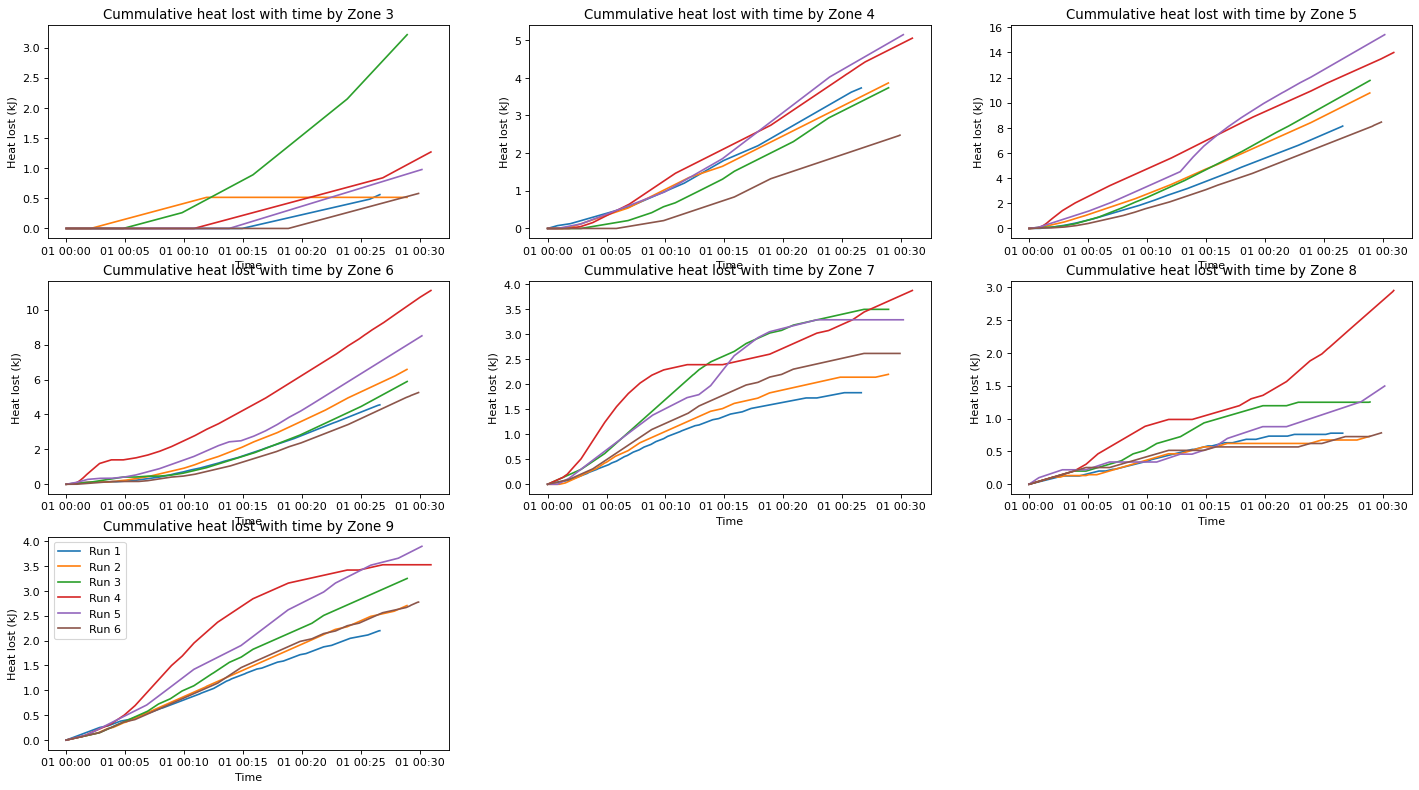

In [27]:
# Comparing different runs 
plt.figure(figsize=(22, 12), dpi=80)
for i in range(0,7):
    plt.subplot(3,3,i+1)
    plt.plot(time_1,heat_lost_compartment_cumsum_1[:,i])
    plt.plot(time_2,heat_lost_compartment_cumsum_2[:,i])
    plt.plot(time_3,heat_lost_compartment_cumsum_3[:,i])
    plt.plot(time_4,heat_lost_compartment_cumsum_4[:,i])
    plt.plot(time_5,heat_lost_compartment_cumsum_5[:,i])
    plt.plot(time_6[:360],heat_lost_compartment_cumsum_6[:360,i])
    
    plt.title('Cummulative heat lost with time by Zone '+str(i+3))
    plt.xlabel('Time')
    plt.ylabel('Heat lost (kJ)')
plt.legend(['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6'])

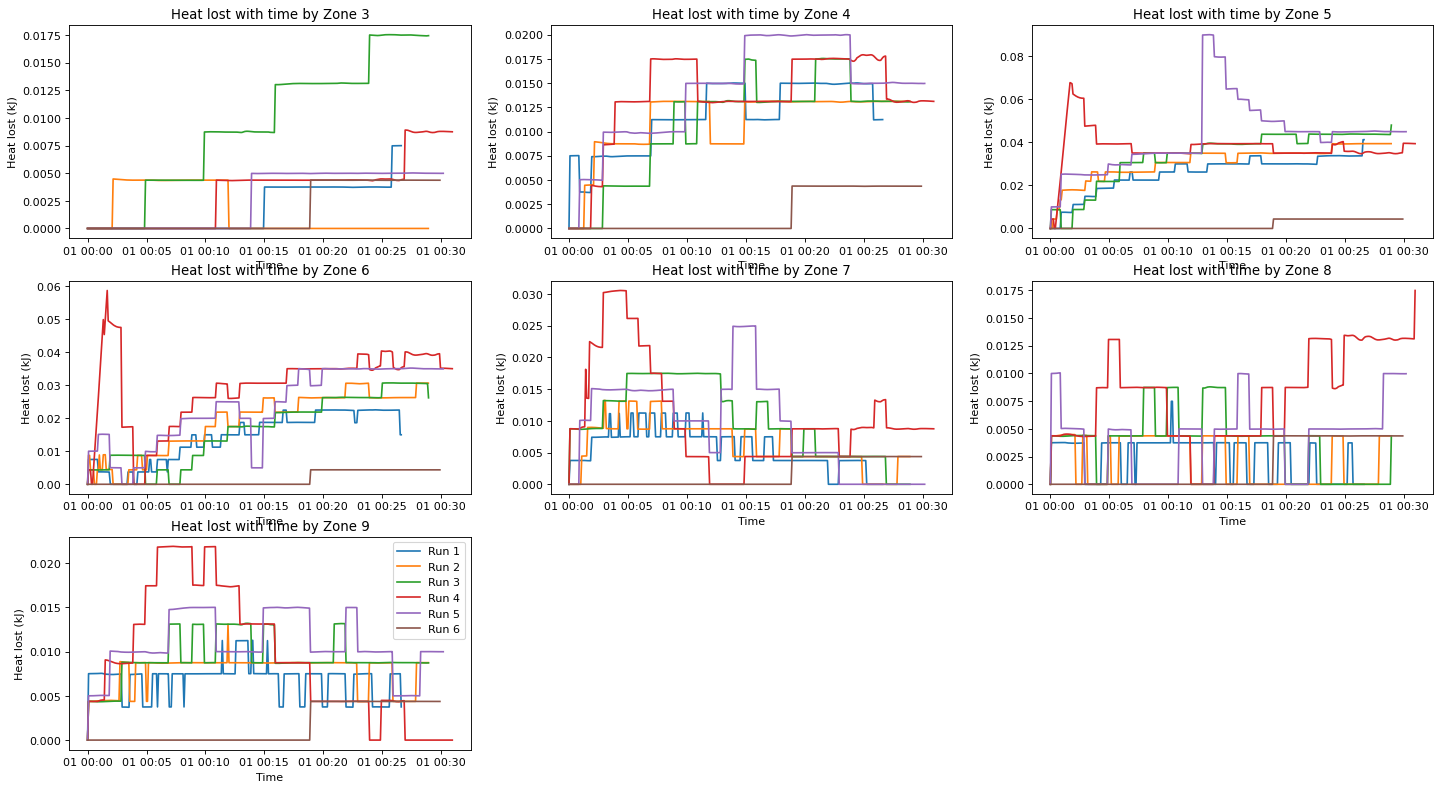

In [28]:
# Comparing different runs 
plt.figure(figsize=(22, 12), dpi=80)
for i in range(0,7):
    plt.subplot(3,3,i+1)
    plt.plot(time_1,heat_lost_compartment_1[:,i])
    plt.plot(time_2,heat_lost_compartment_2[:,i])
    plt.plot(time_3,heat_lost_compartment_3[:,i])
    plt.plot(time_4,heat_lost_compartment_4[:,i])
    plt.plot(time_5,heat_lost_compartment_5[:,i])
    plt.plot(time_6[:360],heat_lost_compartment_6[:360,0])
    
    plt.title('Heat lost with time by Zone '+str(i+3))
    plt.xlabel('Time')
    plt.ylabel('Heat lost (kJ)')
plt.legend(['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6'])


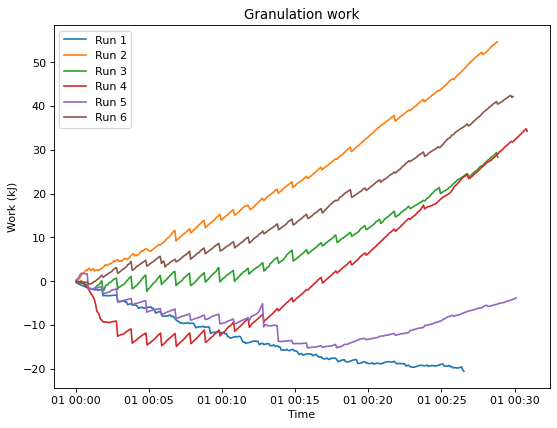

In [29]:

plt.figure(figsize=(8, 6), dpi=80)

plt.plot(time_1,work_granulation_cumsum_1)
plt.plot(time_2,work_granulation_cumsum_2)
plt.plot(time_3,work_granulation_cumsum_3)
plt.plot(time_4,work_granulation_cumsum_4)
plt.plot(time_5,work_granulation_cumsum_5)
plt.plot(time_6[:360],work_granulation_cumsum_6[:360])

plt.title('Granulation work')
plt.xlabel('Time')
plt.ylabel('Work (kJ)')
plt.legend(['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6'])


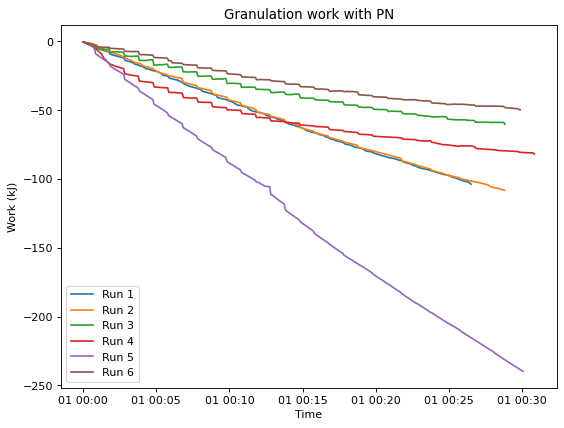

In [30]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(time_1,work_granulation_pn_cumsum_1)
plt.plot(time_2,work_granulation_pn_cumsum_2)
plt.plot(time_3,work_granulation_pn_cumsum_3)
plt.plot(time_4,work_granulation_pn_cumsum_4)
plt.plot(time_5,work_granulation_pn_cumsum_5)
plt.plot(time_6[:360],work_granulation_pn_cumsum_6[:360])

plt.title('Granulation work with PN')
plt.xlabel('Time')
plt.ylabel('Work (kJ)')
plt.legend(['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6'])

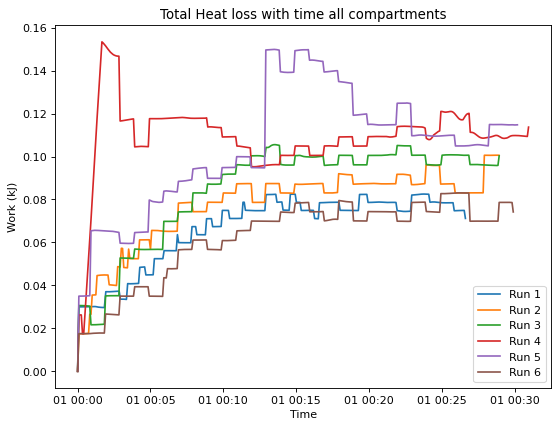

In [31]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(time_1,total_heat_loss_allcomps_with_time_1)
plt.plot(time_2,total_heat_loss_allcomps_with_time_2)
plt.plot(time_3,total_heat_loss_allcomps_with_time_3)
plt.plot(time_4,total_heat_loss_allcomps_with_time_4)
plt.plot(time_5,total_heat_loss_allcomps_with_time_5)
plt.plot(time_6[:360],total_heat_loss_allcomps_with_time_6[:360])

plt.title('Total Heat loss with time all compartments')
plt.xlabel('Time')
plt.ylabel('Work (kJ)')
plt.legend(['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6'])


In [32]:
total_heat_loss_allcomps_1 = np.sum(heat_lost_compartment_1[:],axis=0)
total_heat_loss_allcomps_2 = np.sum(heat_lost_compartment_2[:],axis=0)
total_heat_loss_allcomps_3 = np.sum(heat_lost_compartment_3[:],axis=0)
total_heat_loss_allcomps_4 = np.sum(heat_lost_compartment_4[:],axis=0)
total_heat_loss_allcomps_5 = np.sum(heat_lost_compartment_5[:],axis=0)
total_heat_loss_allcomps_6 = np.sum(heat_lost_compartment_6[:360],axis=0)

total_heat_loss_1 = np.sum(total_heat_loss_allcomps_1) + total_heat_loss_overtime_to_equipment_1
total_heat_loss_2 = np.sum(total_heat_loss_allcomps_2) + total_heat_loss_overtime_to_equipment_2
total_heat_loss_3 = np.sum(total_heat_loss_allcomps_3) + total_heat_loss_overtime_to_equipment_3
total_heat_loss_4 = np.sum(total_heat_loss_allcomps_4) + total_heat_loss_overtime_to_equipment_4
total_heat_loss_5 = np.sum(total_heat_loss_allcomps_5) + total_heat_loss_overtime_to_equipment_5
total_heat_loss_6 = np.sum(total_heat_loss_allcomps_6) + total_heat_loss_overtime_to_equipment_6


work_granulation_total_1 = np.trapz(work_granulation_1) - total_heat_loss_overtime_to_equipment_1
work_granulation_total_2 = np.trapz(work_granulation_2) - total_heat_loss_overtime_to_equipment_2
work_granulation_total_3 = np.trapz(work_granulation_3) - total_heat_loss_overtime_to_equipment_3
work_granulation_total_4 = np.trapz(work_granulation_4) - total_heat_loss_overtime_to_equipment_4
work_granulation_total_5 = np.trapz(work_granulation_5) - total_heat_loss_overtime_to_equipment_5
work_granulation_total_6 = np.trapz(work_granulation_6[:360]) - total_heat_loss_overtime_to_equipment_6

work_granulation_pn_total_1 = np.trapz(work_granulation_pn_1) - total_heat_loss_overtime_to_equipment_1
work_granulation_pn_total_2 = np.trapz(work_granulation_pn_2) - total_heat_loss_overtime_to_equipment_2
work_granulation_pn_total_3 = np.trapz(work_granulation_pn_3) - total_heat_loss_overtime_to_equipment_3
work_granulation_pn_total_4 = np.trapz(work_granulation_pn_4) - total_heat_loss_overtime_to_equipment_4
work_granulation_pn_total_5 = np.trapz(work_granulation_pn_5) - total_heat_loss_overtime_to_equipment_5
work_granulation_pn_total_6 = np.trapz(work_granulation_pn_6[:360]) - total_heat_loss_overtime_to_equipment_6


data = np.vstack((total_heat_loss_allcomps_1,total_heat_loss_allcomps_2))
data = np.vstack((data,total_heat_loss_allcomps_3))
data = np.vstack((data,total_heat_loss_allcomps_4))
data = np.vstack((data,total_heat_loss_allcomps_5))
data = np.vstack((data,total_heat_loss_allcomps_6))

df_total_heat_lost_allcomps = pd.DataFrame(data=data,columns=['Zone 2','Zone 3','Zone 4','Zone 5','Zone 6','Zone 7','Zone 8'])
df_total_heat_lost_allcomps['Run no'] = ['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6']

# total_heat_lost_arr = [total_heat_loss_1,total_heat_loss_2,total_heat_loss_3,total_heat_loss_4,total_heat_loss_5,total_heat_loss_6]
work_gran_arr = np.hstack((work_granulation_total_1,work_granulation_total_2,work_granulation_total_3,work_granulation_total_4,work_granulation_total_5,work_granulation_total_6))
work_gran_pn_arr = np.hstack((work_granulation_pn_total_1,work_granulation_pn_total_2,work_granulation_pn_total_3,work_granulation_pn_total_4,work_granulation_pn_total_5,work_granulation_pn_total_6))
# print(work_gran_arr)
work_gran_df = pd.DataFrame(data=[work_gran_arr],columns=['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6'])
work_gran_pn_df = pd.DataFrame(data=[work_gran_pn_arr],columns=['Run 1','Run 2','Run 3','Run 4','Run 5','Run 6'])




Text(0.5, 1.0, 'Total Granulation work')

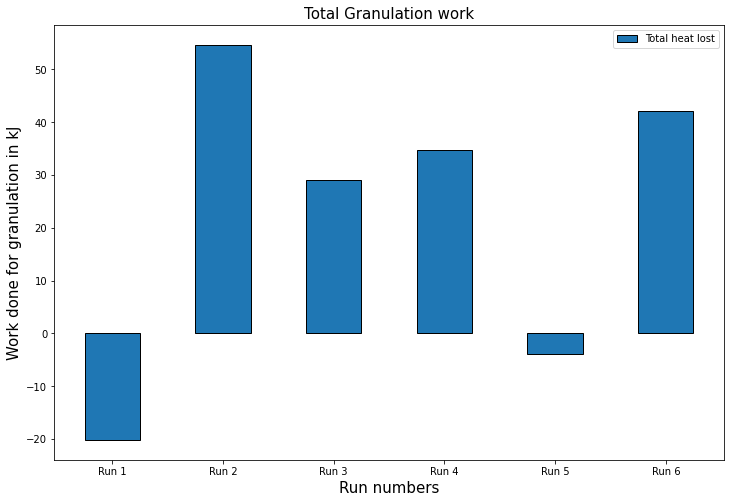

In [33]:
barWidth = 0.5
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
br1 = np.arange(len(work_gran_pn_arr))

# Make the plot
plt.bar(br1, work_gran_arr, color ='tab:blue', width = barWidth,
        edgecolor ='black', label ='Total heat lost')


plt.xticks([r for r in range(len(work_gran_pn_arr))],
        ['Run 1','Run 2','Run 3', 'Run 4', 'Run 5', 'Run 6'])
plt.legend()
plt.xlabel('Run numbers', fontsize = 15)
plt.ylabel('Work done for granulation in kJ', fontsize = 15)
plt.title('Total Granulation work', fontsize = 15)

Text(0.5, 1.0, 'Total Granulation work')

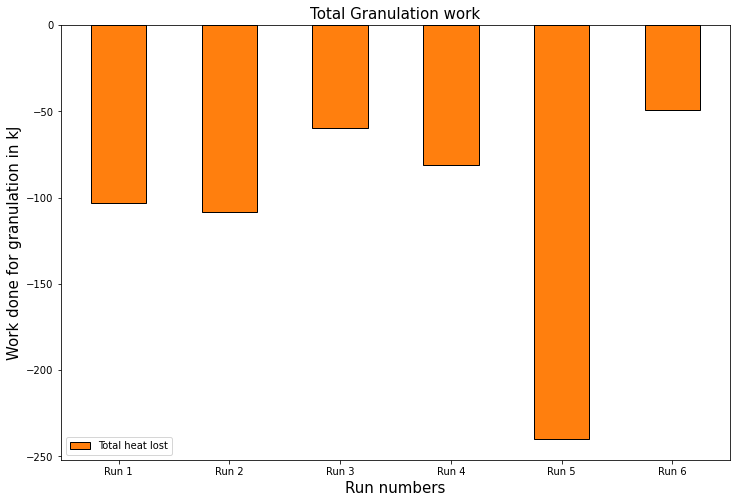

In [34]:
barWidth = 0.5
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
br1 = np.arange(len(work_gran_pn_arr))

# Make the plot
plt.bar(br1, work_gran_pn_arr, color ='tab:orange', width = barWidth,
        edgecolor ='black', label ='Total heat lost')


plt.xticks([r for r in range(len(work_gran_pn_arr))],
        ['Run 1','Run 2','Run 3', 'Run 4', 'Run 5', 'Run 6'])
plt.legend()
plt.xlabel('Run numbers', fontsize = 15)
plt.ylabel('Work done for granulation in kJ', fontsize = 15)
plt.title('Total Granulation work', fontsize = 15)

Text(0.5, 1.0, 'Total heat loss in each TSG zone')

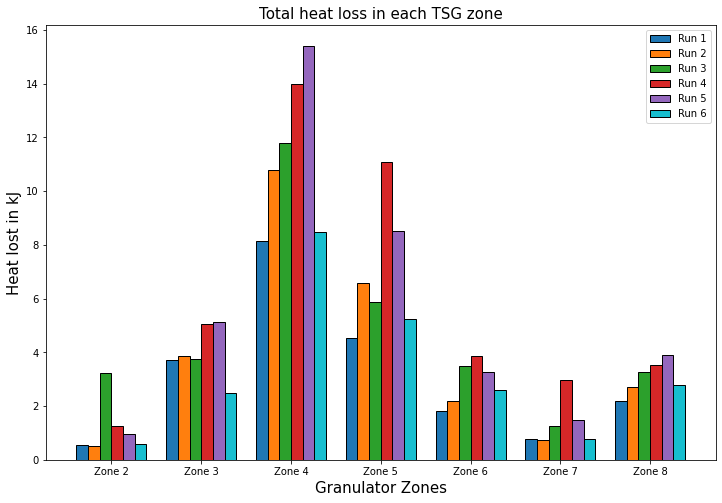

In [35]:
# set width of bar
barWidth = 0.13
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
br1 = np.arange(len(total_heat_loss_allcomps_1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, total_heat_loss_allcomps_1, color ='tab:blue', width = barWidth,
        edgecolor ='black', label ='Run 1')
plt.bar(br2, total_heat_loss_allcomps_2, color ='tab:orange', width = barWidth,
        edgecolor ='black', label ='Run 2')
plt.bar(br3, total_heat_loss_allcomps_3, color ='tab:green', width = barWidth,
        edgecolor ='black', label ='Run 3')
plt.bar(br4, total_heat_loss_allcomps_4, color ='tab:red', width = barWidth,
        edgecolor ='black', label ='Run 4')
plt.bar(br5, total_heat_loss_allcomps_5, color ='tab:purple', width = barWidth,
        edgecolor ='black', label ='Run 5')
plt.bar(br6, total_heat_loss_allcomps_6, color ='tab:cyan', width = barWidth,
        edgecolor ='black', label ='Run 6')

plt.xticks([r + 2.5*barWidth for r in range(len(total_heat_loss_allcomps_1))],
        ['Zone 2','Zone 3', 'Zone 4', 'Zone 5', 'Zone 6', 'Zone 7', 'Zone 8'])
plt.legend()
plt.xlabel('Granulator Zones', fontsize = 15)
plt.ylabel('Heat lost in kJ', fontsize = 15)
plt.title('Total heat loss in each TSG zone', fontsize = 15)

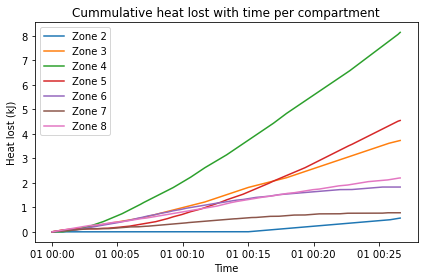

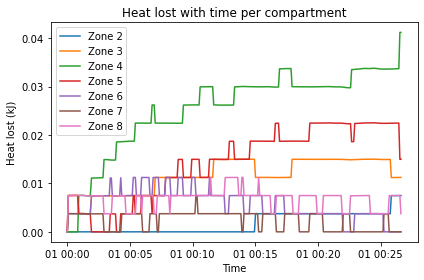

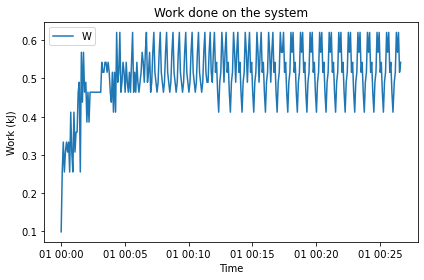

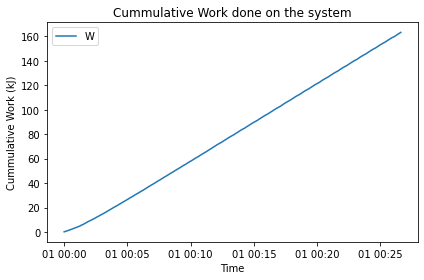

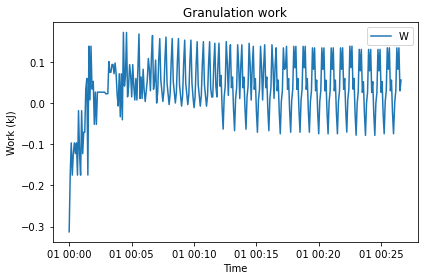

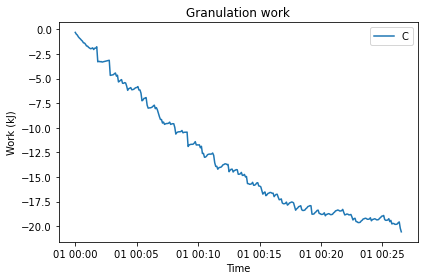

In [36]:
# Single Run plots
plt.figure()
plt.plot(time_1,heat_lost_compartment_cumsum_1)
plt.legend(['Zone 2','Zone 3','Zone 4','Zone 5','Zone 6','Zone 7','Zone 8'])
plt.title('Cummulative heat lost with time per compartment')
plt.xlabel('Time')
plt.ylabel('Heat lost (kJ)')
plt.tight_layout()
# plt.fill_between(time, heat_lost_compartment_cumsum[:,2])
plt.figure()
plt.plot(time_1,heat_lost_compartment_1)
plt.legend(['Zone 2','Zone 3','Zone 4','Zone 5','Zone 6','Zone 7','Zone 8'])
plt.title('Heat lost with time per compartment')
plt.xlabel('Time')
plt.ylabel('Heat lost (kJ)')
plt.tight_layout()

plt.figure()
plt.plot(time_1,tau_diff_ph_actual_1)
plt.legend('Work')
plt.title('Work done on the system')
plt.xlabel('Time')
plt.ylabel('Work (kJ)')
plt.tight_layout()
plt.figure()
plt.plot(time_1,tau_diff_ph_actual_cumsum_1)
plt.legend('Work')
plt.title('Cummulative Work done on the system')
plt.xlabel('Time')
plt.ylabel('Cummulative Work (kJ)')
plt.tight_layout()
plt.figure()
plt.plot(time_1,work_granulation_1)
plt.legend('Work of Granulation')
plt.title('Granulation work')
plt.xlabel('Time')
plt.ylabel('Work (kJ)')
plt.tight_layout()

plt.figure()
plt.plot(time_1,work_granulation_cumsum_1)
plt.legend('Cummulative Work of Granulation')
plt.title('Granulation work')
plt.xlabel('Time')
plt.ylabel('Work (kJ)')
plt.tight_layout()